In [1]:
!mkdir ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download "tongpython/cat-and-dog" --unzip

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from PIL import Image
from IPython.display import display
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [7]:
torch.manual_seed(20)

train_transform = transforms.Compose([
                                      transforms.RandomRotation(10),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.225])
])

test_transform = transforms.Compose([
                                      transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.225])
])

In [8]:
train_data = datasets.ImageFolder(os.path.join('training_set/training_set'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join('test_set/test_set'),transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data,batch_size=64,shuffle=True,num_workers=10)
test_loader = DataLoader(test_data,shuffle=True,batch_size=32,num_workers=10)

class_names = train_data.classes
print(class_names, len(class_names))
print('Training images available: ',len(train_data))
print('Testing images available: ',len(test_data))

['cats', 'dogs'] 2
Training images available:  8005
Testing images available:  2023


In [9]:
model = models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [10]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=False),
    nn.Linear(1280,120),
    nn.ReLU(),
    nn.Linear(120,2),
    nn.Softmax(dim=1)
)

In [11]:
use_cuda =True
if use_cuda and torch.cuda.is_available():
  model = model.cuda()

In [12]:
torch.manual_seed(101)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer,mode='min',patience=5)

In [ ]:
epochs = 16

train_losses = []
train_correct = []
test_losses = []
test_correct = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  for b, (X_train,y_train) in enumerate(tqdm(train_loader)):
    b += 1
    if use_cuda and torch.cuda.is_available():
      X_train = X_train.cuda()
      y_train = y_train.cuda()
    
    y_pred = model(X_train)
    trloss = criterion(y_pred,y_train)

    predicted = torch.max(y_pred.data,1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    trloss.backward()
    optimizer.step()
  scheduler.step(trn_corr)

  train_losses.append(trloss)
  train_correct.append(trn_corr)
  

  model.eval()
  with torch.no_grad():
    for b, (X_test,y_test) in enumerate(tqdm(test_loader)):
      if use_cuda and torch.cuda.is_available():
        X_test = X_test.cuda()
        y_test = y_test.cuda()
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1]
      tst_corr += (predicted == y_test).sum()

    tsloss = criterion(y_val,y_test)
    test_losses.append(tsloss)
    test_correct.append(tst_corr)
    print()
    print(f'Epoch {i+1}, train loss = {trloss.item()}, train accuracy = {trn_corr.item()*100/8005}')
    print(f'Epoch {i+1}, test loss = {tsloss.item()}, test accuracy = {tst_corr.item()*100/2023}')
    print()

Performance after training

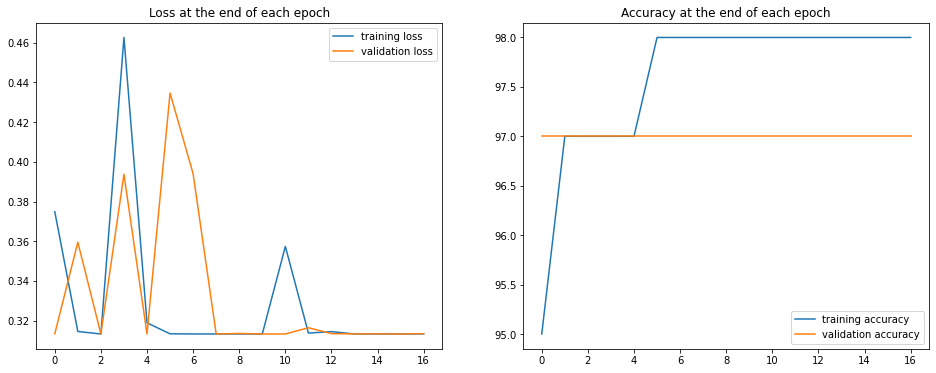

CPU times: user 440 ms, sys: 11 ms, total: 451 ms
Wall time: 492 ms


In [14]:
%%time

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();
plt.subplot(122)
plt.plot([t*100/8005 for t in train_correct], label='training accuracy')
plt.plot([t*100/2023 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();
plt.show()

In [ ]:
from google.colab import files
files.upload()

In [17]:
def predict_image(images):
  model.eval()
  gam = test_transform(images).view(1,3,224,224)
  if use_cuda and torch.cuda.is_available():
    gam = gam.cuda()
  with torch.no_grad():
    pred = model(gam).argmax()
  return class_names[pred.item()]

This is dogs


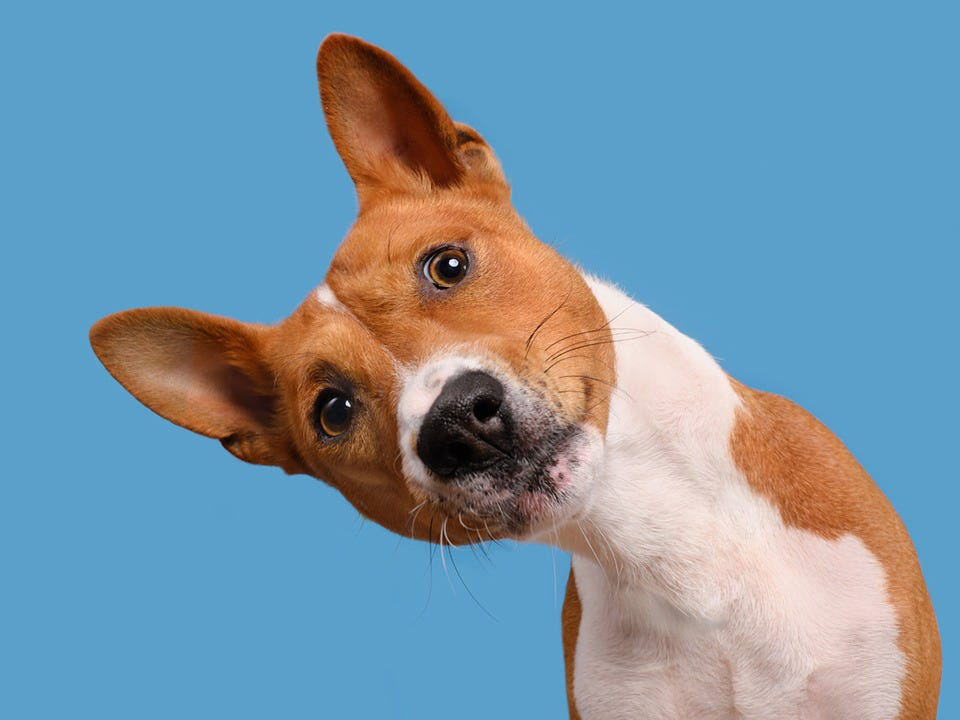

In [20]:
im1 = Image.open('dog1.jpeg')
print('This is', predict_image(im1))
im1

This is dogs


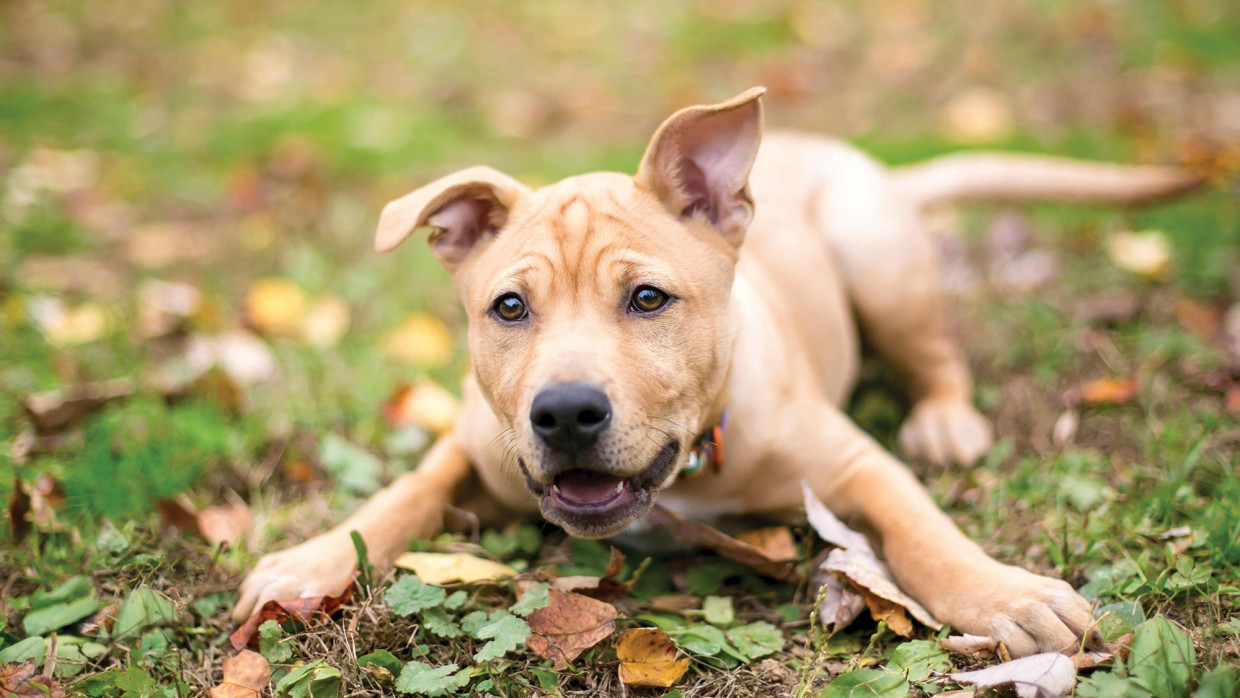

In [21]:
im1 = Image.open('dog2.jpg')
print('This is', predict_image(im1))
im1

This is dogs


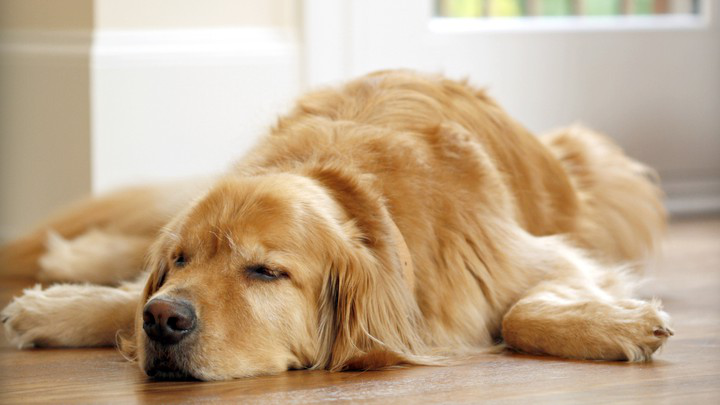

In [22]:
im1 = Image.open('dog3.jpg')
print('This is', predict_image(im1))
im1

This is cats


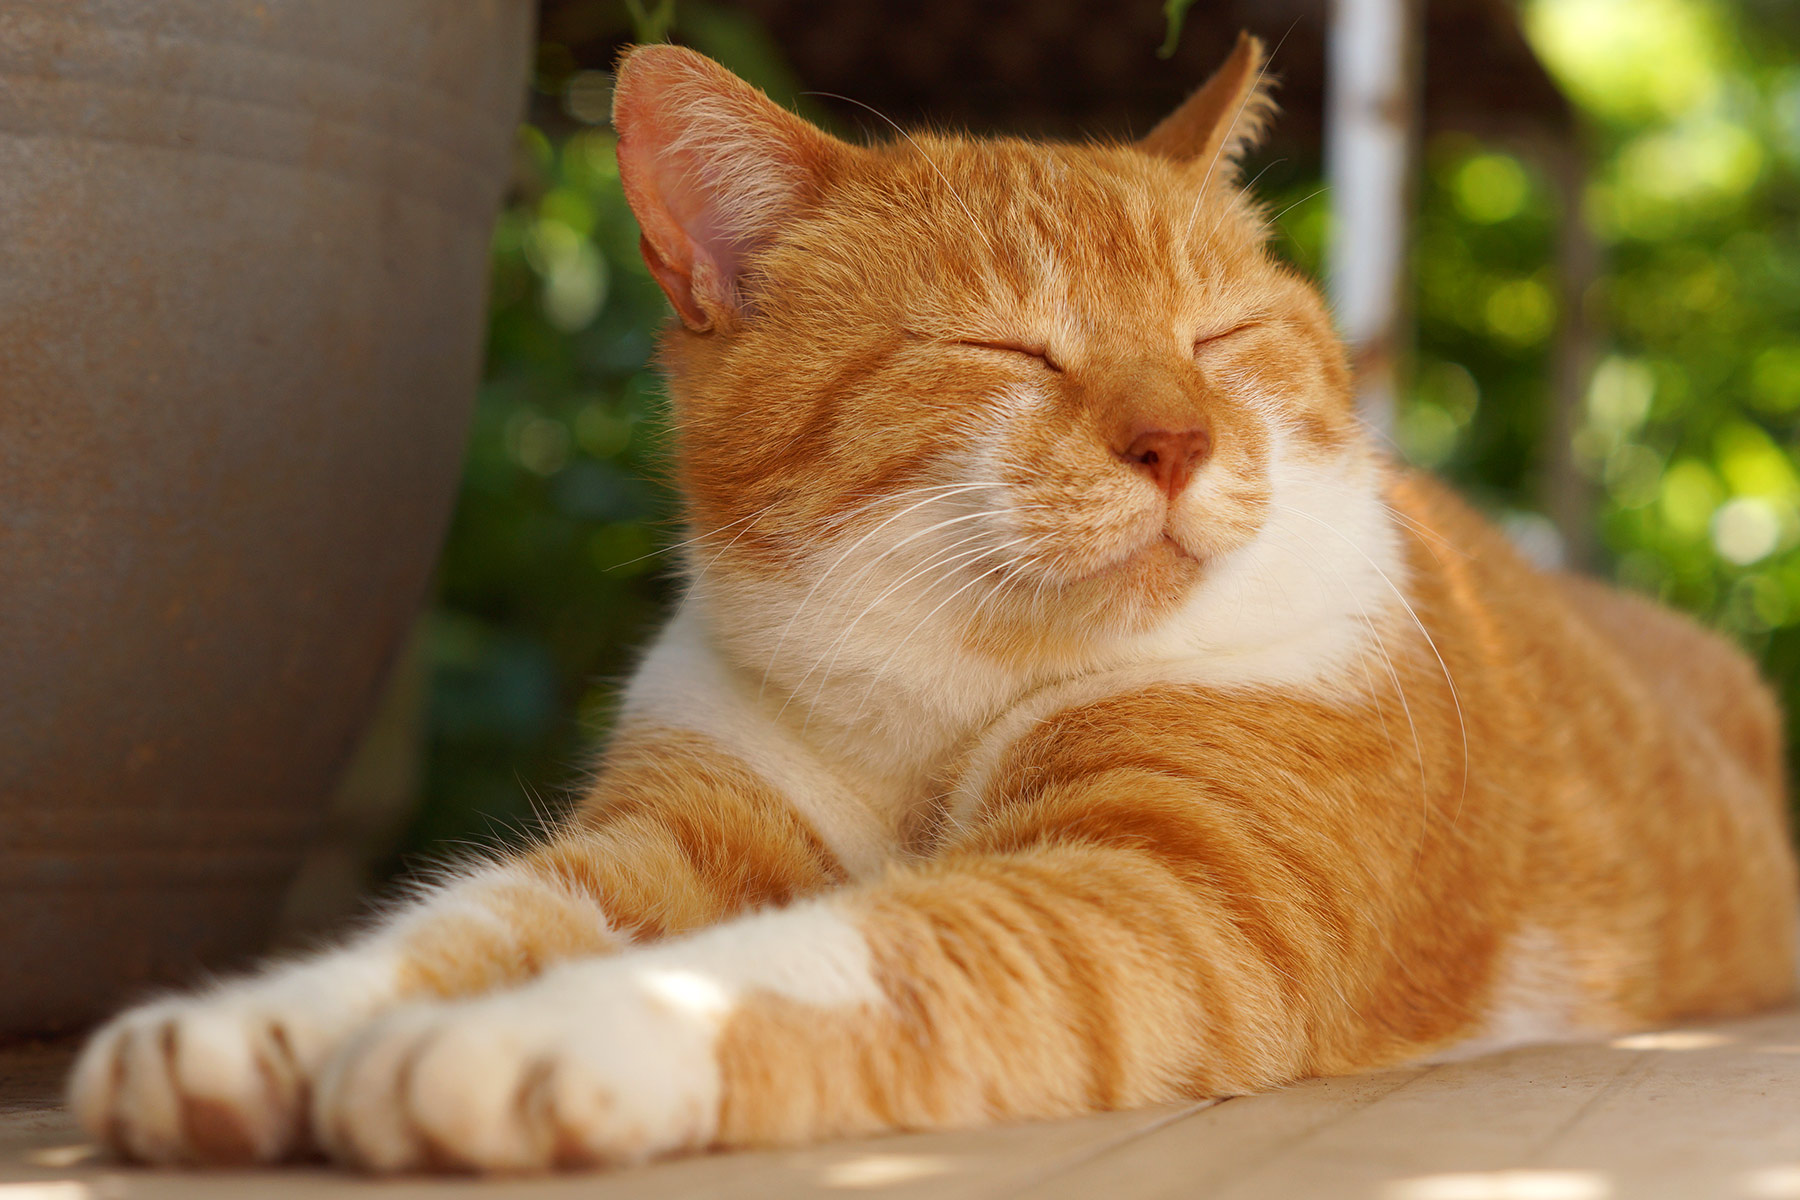

In [23]:
im1 = Image.open('cat1.jpg')
print('This is', predict_image(im1))
im1

This is cats


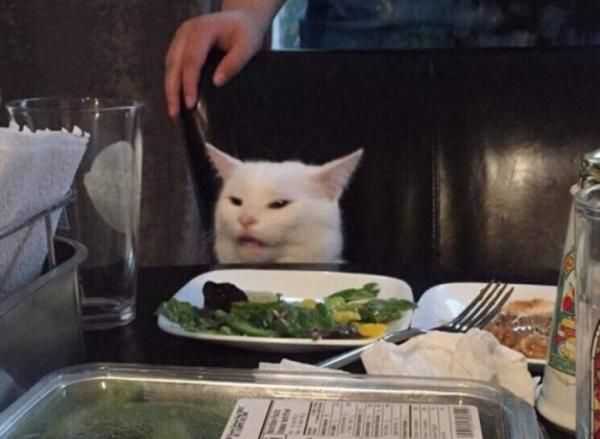

In [24]:
im1 = Image.open('cat2.jpg')
print('This is', predict_image(im1))
im1

This is cats


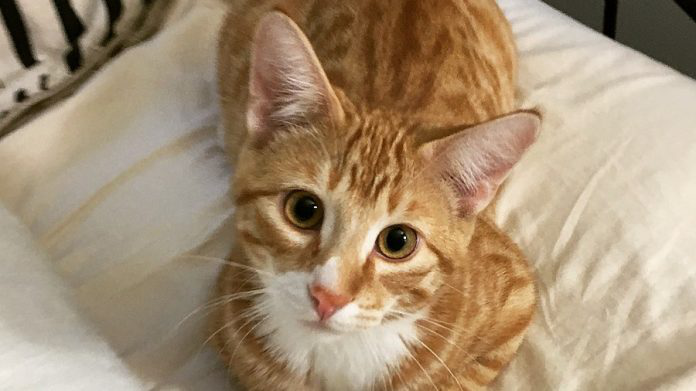

In [25]:
im1 = Image.open('cat3.jpg')
print('This is', predict_image(im1))
im1